In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense
from sklearn.metrics import accuracy_score, classification_report
from google.colab import drive

In [2]:
# Mounting Google Drive to access data
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np

# Read data from CSV file
csv_file_path = "/content/drive/MyDrive/OS_Project/test_codes/optimal_node_data_Test2.csv"
df = pd.read_csv(csv_file_path)

# Specify the metric columns
metrics = ["CPU Load (%)", "Memory Usage (%)", "Battery Level (%)", "Load Average"]

# Normalize Metrics (Min-Max Scaling to avoid negative values)
df[metrics] = (df[metrics] - df[metrics].min()) / (df[metrics].max() - df[metrics].min())

# Group by Node_ID
grouped = df.groupby("Node_ID")

# Calculate Uniformity Metrics
uniformity_scores = {}
for node, group in grouped:
    mean_values = group[metrics].mean()  # Mean for each metric
    std_values = group[metrics].std()   # Standard deviation for each metric

    # Calculate Coefficient of Variation (CV) for each metric
    cv_values = (std_values / mean_values).replace(np.inf, 0).fillna(0)

    # Clamp CV to avoid extreme values
    cv_values = cv_values.clip(lower=-10, upper=10)

    # Average CV across all metrics for this node
    uniformity_score = cv_values.mean()
    uniformity_scores[node] = uniformity_score

# Overall Uniformity Score (Optionally Weighted by Row Count)
overall_uniformity_score = np.mean(list(uniformity_scores.values()))

# Output Results
print("Uniformity Scores by Node:")
for node, score in uniformity_scores.items():
    print(f"{node}: {score:.4f}")

print(f"\nOverall Uniformity Score: {overall_uniformity_score:.4f}")



Uniformity Scores by Node:
node_1: 0.2515
node_2: 0.3517
node_3: 0.5672

Overall Uniformity Score: 0.3902


Dataset Summary:
        optimal_score  CPU Load (%)  Memory Usage (%)  Battery Level (%)  \
count      143.000000    143.000000        143.000000         143.000000   
mean         0.014246     19.415385         61.335664          95.664336   
std          0.005765     10.320930          3.929903           8.270041   
min          0.002475      4.300000         53.299999          80.000000   
25%          0.011136     14.100000         59.350000         100.000000   
50%          0.013369     17.700001         62.200001         100.000000   
75%          0.016556     21.450000         64.400002         100.000000   
max          0.047170    100.000000         69.199997         100.000000   

       Load Average  
count    143.000000  
mean       2.432965  
std        0.889281  
min        1.239258  
25%        1.854492  
50%        2.312988  
75%        2.798096  
max        7.529785  

Variance of Metrics per Node:
         CPU Load (%)  Memory Usage (%)  Battery Level (%)  Load Aver

<Figure size 1000x600 with 0 Axes>

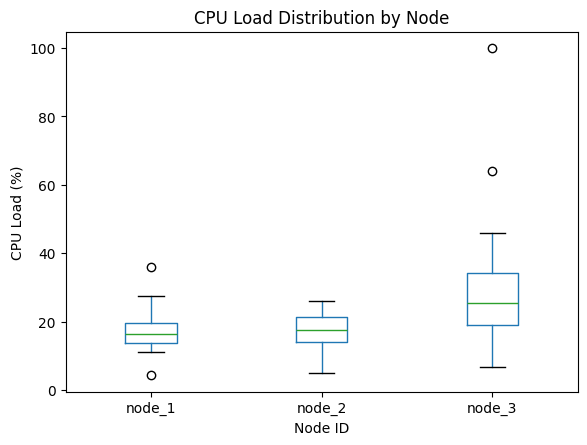

<Figure size 1000x600 with 0 Axes>

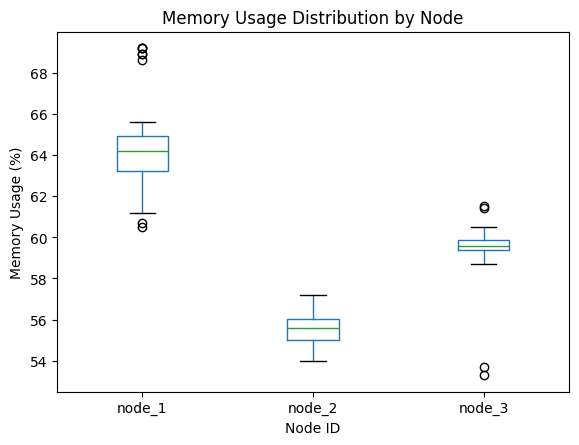

<Figure size 1000x600 with 0 Axes>

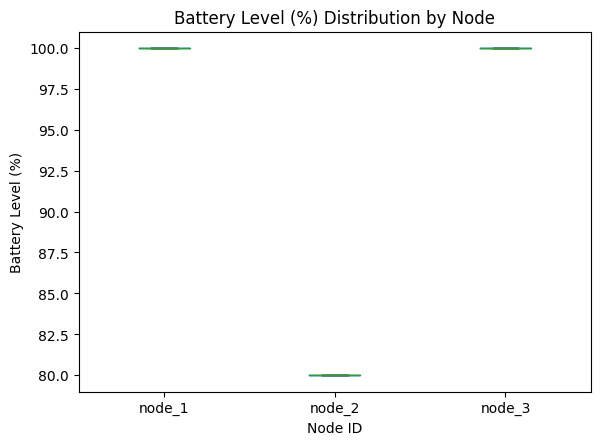

<Figure size 1000x600 with 0 Axes>

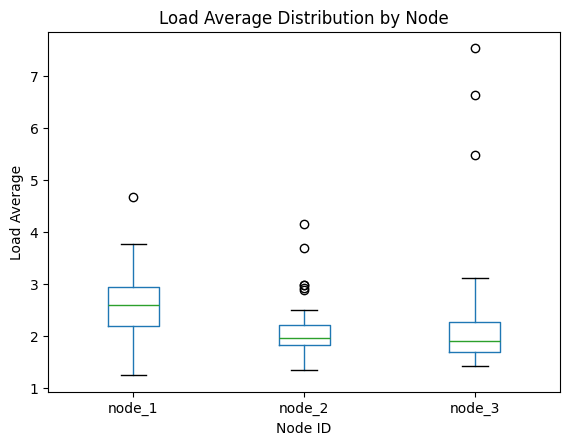

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/OS_Project/test_codes/optimal_node_data_Test2.csv')

# Summarize data
print("Dataset Summary:")
print(df.describe())

# Group data by Node ID
grouped = df.groupby('Node_ID').mean()

# Compute Variance for Metrics
variance_metrics = df.groupby('Node_ID')[['CPU Load (%)', 'Memory Usage (%)', 'Battery Level (%)', 'Load Average']].var()
print("\nVariance of Metrics per Node:")
print(variance_metrics)

# Calculate uniformity using entropy
from scipy.stats import entropy

def calculate_uniformity(df, column):
    counts = df[column].value_counts()
    return entropy(counts)

uniformity = calculate_uniformity(df, 'Node_ID')
print(f"\nUniformity (Entropy) of Node Assignment: {uniformity:.4f}")

# Visualize CPU Load distribution
plt.figure(figsize=(10, 6))
df.boxplot(column='CPU Load (%)', by='Node_ID', grid=False)
plt.title('CPU Load Distribution by Node')
plt.suptitle('')
plt.xlabel('Node ID')
plt.ylabel('CPU Load (%)')
plt.show()

# Visualize CPU Load distribution
plt.figure(figsize=(10, 6))
df.boxplot(column='Memory Usage (%)', by='Node_ID', grid=False)
plt.title('Memory Usage Distribution by Node')
plt.suptitle('')
plt.xlabel('Node ID')
plt.ylabel('Memory Usage (%)')
plt.show()

# Visualize CPU Load distribution
plt.figure(figsize=(10, 6))
df.boxplot(column='Battery Level (%)', by='Node_ID', grid=False)
plt.title('Battery Level (%) Distribution by Node')
plt.suptitle('')
plt.xlabel('Node ID')
plt.ylabel('Battery Level (%)')
plt.show()

# Visualize CPU Load distribution
plt.figure(figsize=(10, 6))
df.boxplot(column='Load Average', by='Node_ID', grid=False)
plt.title('Load Average Distribution by Node')
plt.suptitle('')
plt.xlabel('Node ID')
plt.ylabel('Load Average')
plt.show()

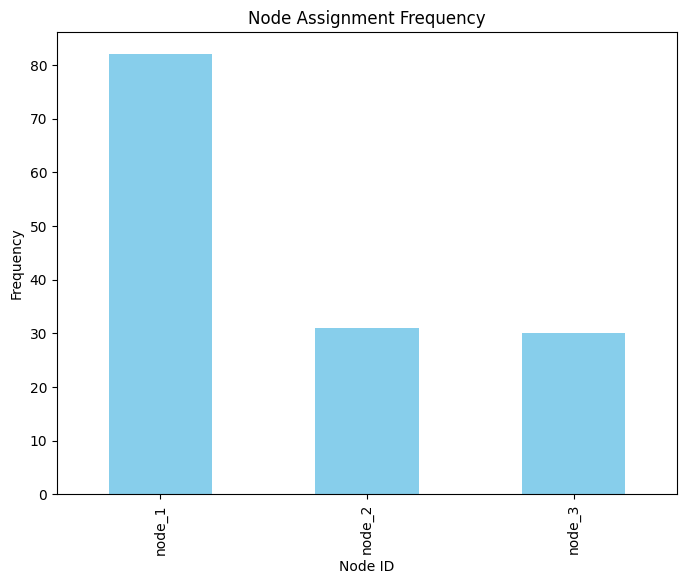


Node Assignment Frequency:
Node_ID
node_1    82
node_2    31
node_3    30
Name: count, dtype: int64


In [5]:
# Calculate node assignment frequency
node_counts = df['Node_ID'].value_counts()

# Visualize node assignment frequency
node_counts.plot(kind='bar', color='skyblue', figsize=(8, 6))
plt.title('Node Assignment Frequency')
plt.xlabel('Node ID')
plt.ylabel('Frequency')
plt.show()

print("\nNode Assignment Frequency:")
print(node_counts)


In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load data from CSV
file_path = '/content/drive/MyDrive/OS_Project/test_codes/optimal_node_data_Test2.csv'
df = pd.read_csv(file_path)

# Set the node names as the index
df.set_index("Node_ID", inplace=True)

# Drop non-metric columns if present
df = df.drop(columns=['optimal_score'], errors='ignore')

# Standardize Metrics
scaler = StandardScaler()
standardized_metrics = scaler.fit_transform(df)

# Compute Pairwise Euclidean Distances
num_nodes = len(df)
distances = np.zeros((num_nodes, num_nodes))

for i in range(num_nodes):
    for j in range(num_nodes):
        distances[i, j] = np.linalg.norm(standardized_metrics[i] - standardized_metrics[j])

# Aggregate Distances and Compute Variance-Based Uniformity Score
uniformity_score = np.var(distances)  # Variance-based uniformity score

# Output Results
print("Pairwise Distances Matrix:")
print(pd.DataFrame(distances, index=df.index, columns=df.index))
print("\nUniformity Score (lower is better):", uniformity_score)


Pairwise Distances Matrix:
Node_ID    node_2    node_1    node_1    node_1    node_1    node_3    node_3  \
Node_ID                                                                         
node_2   0.000000  2.978404  3.472392  3.645331  3.725139  3.019979  2.997712   
node_1   2.978404  0.000000  1.235297  1.379759  1.717353  2.356198  2.006548   
node_1   3.472392  1.235297  0.000000  0.478016  0.493544  3.179447  2.472356   
node_1   3.645331  1.379759  0.478016  0.000000  0.671777  3.144972  2.394124   
node_1   3.725139  1.717353  0.493544  0.671777  0.000000  3.527277  2.751661   
...           ...       ...       ...       ...       ...       ...       ...   
node_1   7.481414  6.394102  5.268235  5.343978  4.798496  7.837536  7.057614   
node_3   4.060048  3.144669  2.405442  2.786096  2.165714  4.578454  3.923551   
node_2   1.489551  3.727367  4.384534  4.657460  4.664914  3.761581  3.999360   
node_1   3.879625  1.495033  0.938092  1.101047  1.143551  3.764116  3.214073   
n